# Calculating White Noise Forcing

This ipython notebook is written for calculating the white noise forcing that needed by Linear Inverse Modeling (LIM).

A LIM is given by
$$
M(t_0+\tau) = G_{\tau} M(t_0) + \epsilon
$$
where $M$ is the state vector that we want to predict, $t_0$ is the initial time, $\tau$ is the forecast lead time, $G_{\tau}$ is the linear operator (or Jacobian). $\epsilon$ is the white noise forcing (or covariance matrix) preventing the model end up to trivial solution. The value of $\epsilon$ must ensure that the variance of the model climatology is stable and identical to the climatology of data. From physical perspective, the forcing ($\epsilon$) must balance the dissipation process ($G_{\tau} M(t)$), so the model is stable for long-term simulations.

## Packages

In [1]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
from util.plotter import plot_phase

## Read Data

In [3]:
M     = np.load("M.npy")
dM_dt = np.roll(M, -1, axis = 1) - M # using Euler method to ensure the mathematical consistency
G     = expm(np.dot(dM_dt, M.T).dot(np.linalg.inv(np.dot(M, M.T)))) # Jacobian matrix

## Calculating the Noise

As we mentioned in the beginning, the value of the covariance matrix must ensure that the climatology of model is stable. Namely,
$$
M(t_0+\tau) M(t_0+\tau)^{T} = (G_{\tau} M(t_0) + \epsilon) (G_{\tau} M(t_0) + \epsilon)^{T}
$$
$$
\Rightarrow M(t_0+\tau) M(t_0+\tau)^{T} = G_{\tau} M(t_0) M(t_0)^{T} G_{\tau}^{T} + 2 G_{\tau} M(t_0) \epsilon + \epsilon \epsilon^{T}
$$
If we are calculating the homogeneous forcing for the entire phase space, the $2 G_{\tau} M(t_0) \epsilon$ term equals $0$ because the white noise is orthogonal to $G_{\tau} M(t_0)$. Hence the covariance matrix is given by
$$
\epsilon \epsilon^{T} = M(t_0+\tau) M(t_0+\tau)^{T} - G_{\tau} M(t_0) M(t_0)^{T} G_{\tau}^{T}
$$

However, when it comes to the state-dependent forcing, the above equation fails because the orthogonality between $\epsilon$ and $G_{\tau} M(t)$ cannot be assured. Therefore, we calculate the covariance matrix as the residual of the linear regression
$$
\epsilon \epsilon^{T} = (M(t_0+\tau) - G_{\tau} M(t_0)) (M(t_0+\tau) - G_{\tau} M(t_0))^{T}
$$

The process of calculation can be summarized as follows:
1. Choose a position in phase space.
2. Aggregate several nearest points as the input (the ```X_0``` in the following code), the next timesteps of those points as the output (the ```X_1``` in the following code).
3. Calculate the residual.

In [4]:
xx   = np.arange(-4, 4+1e-4, 0.02)
yy   = np.arange(-4, 4+1e-4, 0.02)
X, Y = np.meshgrid(xx, yy)

In [7]:
X_0 = np.copy(M)
X_1 = np.copy(np.roll(M, -1, axis = 1))

cov = np.zeros(X.shape + (2, 2,))
for j, y in enumerate(yy):
    for i, x in enumerate(xx):
        distance = (M - np.array([[x], [y]]))
        distance = np.sqrt(np.sum(np.square(distance), axis = 0))
        Xin  = X_0[:, np.where(distance <= np.percentile(distance, 2))[0]]
        Xout = X_1[:, np.where(distance <= np.percentile(distance, 2))[0]]
        residual  = (Xout - G.dot(Xin))
        cov[j, i] = residual.dot(residual.T) / Xin.shape[1]
np.save("noise.npy", cov)

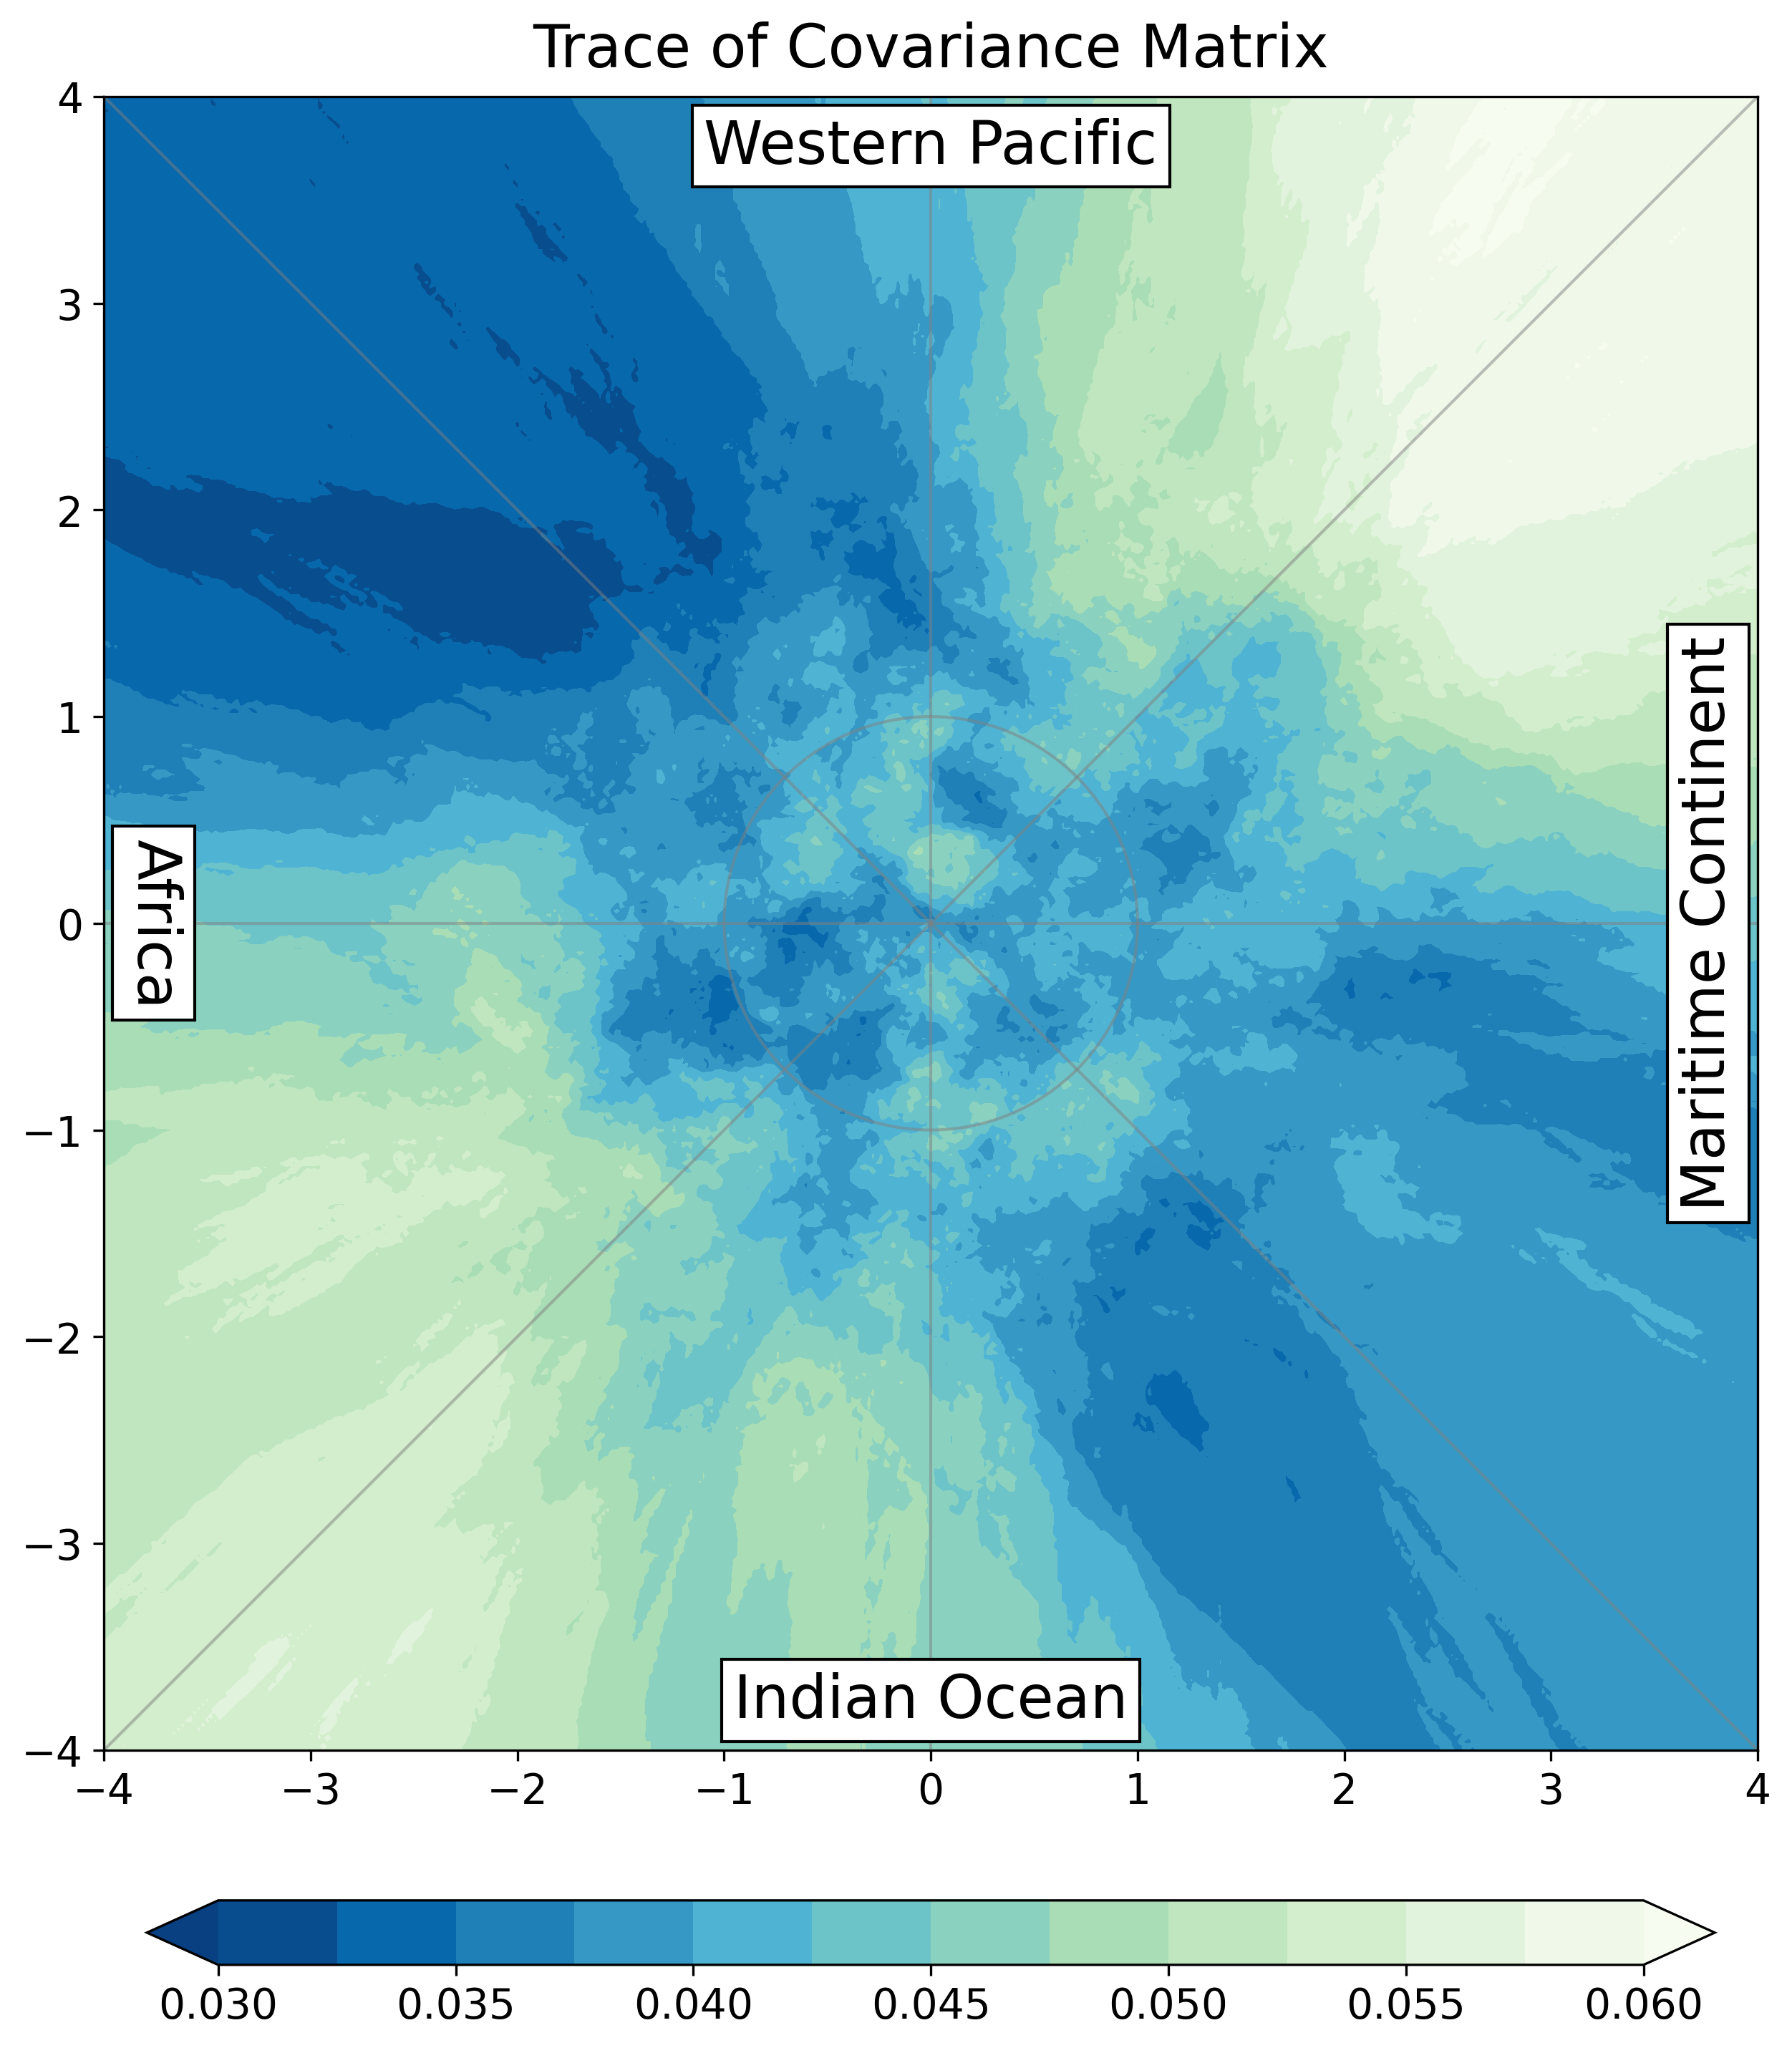

In [9]:
cov = np.load("noise.npy")

fig = plt.figure(figsize = (10, 10), dpi = 300)
ax = plt.axes()
ax.set_aspect("equal")
axc = plt.contourf(X, Y, cov[:, :, 0, 0] + cov[:, :, 1, 1], cmap = "GnBu_r", levels = np.arange(0.03, 0.06+1e-8, 0.0025), extend = "both")
plot_phase(ax)

ax.tick_params(axis = "both", which = "major", labelsize = 14)
plt.xlim([-4, 4]); plt.ylim([-4, 4])
plt.title("Trace of Covariance Matrix", fontsize = 20, pad = 10)

plt.text(-3.9, 0, "Africa", fontsize = 20, ha = "left", va = "center", rotation = 270, bbox = dict(facecolor="white", edgecolor="black"))
plt.text(0, -3.9, "Indian Ocean", fontsize = 20, ha = "center", va = "bottom", rotation = 0, bbox = dict(facecolor="white", edgecolor="black"))
plt.text(3.9, 0, "Maritime Continent", fontsize = 20, ha = "right", va = "center", rotation = 90, bbox = dict(facecolor="white", edgecolor="black"))
plt.text(0, 3.9, "Western Pacific", fontsize = 20, ha = "center", va = "top", rotation = 0, bbox = dict(facecolor="white", edgecolor="black"))

cbox = fig.add_axes([ax.get_position().x0 + 0.02, ax.get_position().y0 - 0.1, ax.get_position().x1 - ax.get_position().x0 - 0.04, 0.03])
cbar = plt.colorbar(axc, cax = cbox, orientation = "horizontal")
cbox.tick_params(axis = "x", labelsize = 14)